In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import utils, datasets, transforms
from torch.utils.data import random_split
import torch.nn as nn

In [76]:
DATA_DIR = '/kaggle/input/shark-species/sharks/'

In [77]:
class_list = os.listdir(DATA_DIR)

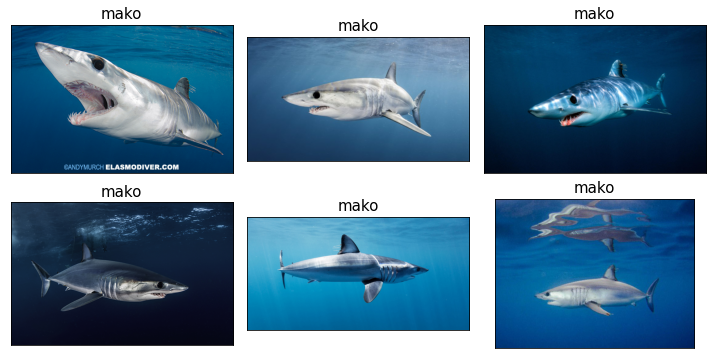

In [78]:
#np.random.seed(42)
fig = plt.figure(figsize=(10, 5))
selected_class = np.random.choice(class_list)
selected_files = os.listdir(DATA_DIR+f'{selected_class}')

for i, file in enumerate(selected_files[5:11]):
  img = Image.open(DATA_DIR+f'{selected_class}/'+file)
  #print('Image shape: ', np.array(img).shape)
  ax = fig.add_subplot(2, 3, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img)
  ax.set_title(f'{selected_class}', size=15)
plt.tight_layout()
plt.show()

In [79]:
def readImg(path):
    img = Image.open(path)
    return img

In [80]:
transform = transforms.Compose([transforms.Resize((128,128),interpolation=Image.Resampling.NEAREST),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.Grayscale(),
                                 transforms.ToTensor()])

In [81]:
dataset = datasets.ImageFolder(DATA_DIR, transform=transform, loader=readImg)

In [82]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)

In [83]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

tensor(0)


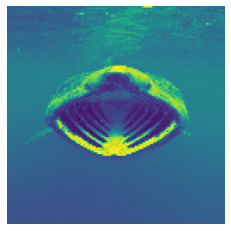

In [84]:
images, labels = next(iter(dataloader))
# helper.imshow(images[0], normalize=False)
imshow(images[0], normalize=False)
print(labels[0])

In [85]:
# for img, label in dataloader:
#     print(label)

In [86]:
dataset.class_to_idx

{'basking': 0,
 'blacktip': 1,
 'blue': 2,
 'bull': 3,
 'hammerhead': 4,
 'lemon': 5,
 'mako': 6,
 'nurse': 7,
 'sand tiger': 8,
 'thresher': 9,
 'tiger': 10,
 'whale': 11,
 'white': 12,
 'whitetip': 13}

In [87]:
len_img=len(dataset)
len_train=int(0.8*len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_dl,val_dl=random_split(dataset,
                             [len_train,len_val]) # random split 80/20

print("train dataset size:", len(train_dl))
print("validation dataset size:", len(val_dl))

train dataset size: 1236
validation dataset size: 310


In [88]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        
        # Max pool 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        # Convolution 4
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0)
        self.relu4 = nn.ReLU()
        
        # Max pool 3
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(128*4*4, 13) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Convolution 3 
        out = self.cnn3(out)
        out = self.relu3(out)
        
        # Max pool 3 
        out = self.maxpool3(out)
        
        # Convolution 4 
        out = self.cnn4(out)
        out = self.relu4(out)
        
        # Max pool 2 
        out = self.maxpool4(out)
        
        # flatten
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

# batch_size, epoch and iteration
batch_size = 128
n_iters = 25
num_epochs = 30


# data loader
train_loader = torch.utils.data.DataLoader(train_dl, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(val_dl, batch_size = batch_size, shuffle = False)
    
# Create CNN
model = CNNModel()

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [89]:
model.parameters

<bound method Module.parameters of CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=13, bias=True)
)>

In [98]:
import torch.nn.functional as F
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1], pred.shape[2], pred.shape[3], pred.shape[4], pred.shape[5], pred.shape[6], pred.shape[7], pred.shape[8], pred.shape[9], pred.shape[10], pred.shape[11], pred.shape[12], pred.shape[13]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)
# def calc_accuracy(mdl, X, Y):
#     # reduce/collapse the classification dimension according to max op
#     # resulting in most likely label
#     max_vals, max_indices = mdl(X).max(1)
#     # assumes the first dimension is batch size
#     n = max_indices.size(0)  # index 0 for extracting the # of elements
#     # calulate acc (note .item() to do float division)
#     acc = (max_indices == Y).sum().item() / n
#     return acc

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [99]:
import time
train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    
    start = time.time()
    
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    _iter = 1
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    # Training
    for images, labels in train_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        print(images.shape)
        print(labels.shape)
        #Reset Grads
        optimizer.zero_grad()
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss & Backward, Update Weights (Step)
        loss = error(preds, labels)
        loss.backward()
        optimizer.step()
        
        #Append loss & acc
        loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        train_epoch_accuracy.append(acc)
        
        if _iter % 500 == 0:
            print("> Iteration {} < ".format(_iter))
            print("Iter Loss = {}".format(round(loss_value, 4)))
            print("Iter Accuracy = {} % \n".format(acc))
        
        _iter += 1
    
    #Validation
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss
        loss = error(preds, labels)
        
        #Append loss & acc
        loss_value = loss.item()
        val_epoch_loss.append(loss_value)
        val_epoch_accuracy.append(acc)
    
    
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    #val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    end = time.time()
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
    #Print Epoch Statistics
    #print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    #print("Train Loss = {}".format(round(train_epoch_loss, 4)))
    print("Train Accuracy = {} %....Val Accuracy = {} % \n".format(train_epoch_accuracy, val_epoch_accuracy))
    #print("Val Loss = {}".format(round(val_epoch_loss, 4)))
    #print("Val Accuracy = {} % \n".format(val_epoch_accuracy))

torch.Size([128, 1, 128, 128])
torch.Size([128])


IndexError: tuple index out of range

In [ ]:
torch.save(model, '/kaggle/working/')